In [1]:
# imports
import pandas as pd 
import numpy as np 
import nltk
import re
# !pip install spacy==2.2.3
# !python -m spacy download en_core_web_sm
# !pip install beautifulsoup4==4.9.1
# !pip install textblob==0.15.3
# !pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall
import gensim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras import Sequential

import preprocess_kgptalkie as ps


2023-04-01 13:57:40.976398: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-01 13:57:40.978092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-01 13:57:41.008152: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-01 13:57:41.008576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 13:57:41.507336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
df_real = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')
df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
unknown_pub = []
for idx, row in enumerate(df_real.text.values):
    try:
        record = row.split('-', maxsplit=1)
        assert(len(record[0]) < 120)
    except:
        unknown_pub.append(idx)

In [5]:
len(unknown_pub)

221

In [6]:
df_real.iloc[unknown_pub].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 221, dtype: object

In [7]:
df_real = df_real.drop(8970, axis = 0)
publisher = []
tmp_text = []
for idx, row in enumerate(df_real.text.values):
    if idx in unknown_pub:
        tmp_text.append(row)
        publisher.append('unknown')
    else:
        record = row.split('-', maxsplit=1)
        tmp_text.append(record[1].strip())
        publisher.append(record[0].strip())

In [8]:
df_real['publisher'] = publisher
df_real.text = tmp_text
df_real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [9]:
empty_fake_data = [index for index, text in enumerate(df_fake.text.tolist()) if str(text).strip() == "" ]
df_fake.iloc[empty_fake_data]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [10]:
df_real.text = df_real.title + " " + df_real.text
df_fake.text = df_fake.title + " " + df_fake.text
df_fake.text = df_fake.text.apply(lambda x:str(x).lower())
df_real.text = df_real.text.apply(lambda x:str(x).lower())

In [11]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends out embarrassing new year’...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian ...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes an internet joke...,News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,trump is so obsessed he even has obama’s name...,News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis just called out donald trump dur...,News,"December 25, 2017"


In [12]:
df_real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...","as u.s. budget fight looms, republicans flip t...",politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,u.s. military to accept transgender recruits o...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior u.s. republican senator: 'let mr. muell...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped by australian diplomat...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,trump wants postal service to charge 'much mor...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [13]:
df_real['real'] = 1
df_fake['real'] = 0
df_fake = df_fake[['text', 'real']]
df_real = df_real[['text', 'real']]

In [14]:
df = df_real.append(df_fake, ignore_index=True)
df.head()
df['real'].mean()

/tmp/ipykernel_7820/559816512.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_real.append(df_fake, ignore_index=True)


0.47700291778960735

In [15]:
df.text.apply(lambda x:ps.remove_special_chars(x))
df.to_csv('preprocessed_data.csv')
x = [row.split() for row in df.text.tolist()]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [16]:
def preprocess_data(x_test):
    unknown_pub = []
    for idx, row in enumerate(x_test.text.values):
        try:
            record = row.split('-', maxsplit=1)
            assert(len(record[0]) < 120)
        except:
            unknown_pub.append(idx)
    publisher = []
    tmp_text = []
    for idx, row in enumerate(x_test.text.values):
        if idx in unknown_pub:
            tmp_text.append(row)
            publisher.append('unknown')
        else:
            tmp_text.append(row)
            publisher.append('unknown')
    x_test['publisher'] = publisher
    x_test.text = tmp_text
    x_test.text = x_test.title + " " + x_test.text
    x_test.text = x_test.text.apply(lambda x:str(x).lower())
    x_test.text.apply(lambda x:ps.remove_special_chars(x))
    x_test_preprocessed = [row.split() for row in x_test.text.tolist()]
    x_test_preprocessed = tokenizer.texts_to_sequences(x_test_preprocessed)
    x_test_preprocessed = pad_sequences(x_test_preprocessed, maxlen = 1000)
    return x_test_preprocessed

In [17]:
fake = pd.read_csv('news_articles.csv')
fake['label'] = fake['label'].replace({'Real':1,'Fake':0})
fake = fake.dropna(axis=0)
fake.isna().sum()
temp = pd.DataFrame(fake[['title','text']])
a = preprocess_data(temp)
a_actual = fake['label']

In [ ]:
new = pd.read_csv('train.csv')
new

In [18]:
y = df.real.values
x = [row.split() for row in df.text.tolist()]

In [19]:
word2vec = gensim.models.Word2Vec(sentences=x, window=5, min_count = 1)

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
X = tokenizer.texts_to_sequences(x)
X = pad_sequences(X, maxlen = 1000)
total_words = len(tokenizer.word_index) + 1

In [21]:

print(X.shape)
print(a.shape)
# X = np.append(X, a)
y = np.append(y, a_actual)
# print(X.shape)
# print(y.shape)
X = np.concatenate((X,a))

(44897, 1000)
(2045, 1000)


In [22]:
def get_weights(model):
    weights = np.zeros((total_words, 100))

    for word, i in tokenizer.word_index.items():
        weights[i] = word2vec.wv[word]
    return weights

In [23]:
embedding_vectors = get_weights(word2vec)
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [24]:
model = Sequential([
    Embedding(total_words, output_dim = 100, weights=[embedding_vectors], input_length = 1000, trainable=False),
    LSTM(units = 128),
    Dropout(0.2),
    Dense(256),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         37537400  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 37,687,929
Trainable params: 150,529
Non-trainable params: 37,537,400
_________________________________________________________________


2023-04-01 13:59:09.886792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 13:59:09.888001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 13:59:09.888610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [25]:
model.fit(x_train, y_train, validation_split=0.3, epochs=6)


Epoch 1/6


2023-04-01 13:59:10.150022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 13:59:10.151563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 13:59:10.152311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

771/771 [==============================] - ETA: 0s - loss: 0.1768 - acc: 0.9315

2023-04-01 14:02:23.098226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 14:02:23.099239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 14:02:23.099875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

771/771 [==============================] - 224s 289ms/step - loss: 0.1768 - acc: 0.9315 - val_loss: 0.1600 - val_acc: 0.9355
Epoch 2/6
771/771 [==============================] - 234s 303ms/step - loss: 0.0930 - acc: 0.9671 - val_loss: 0.0870 - val_acc: 0.9722
Epoch 3/6
771/771 [==============================] - 236s 306ms/step - loss: 0.0682 - acc: 0.9754 - val_loss: 0.0625 - val_acc: 0.9768
Epoch 4/6
771/771 [==============================] - 234s 304ms/step - loss: 0.0429 - acc: 0.9850 - val_loss: 0.0670 - val_acc: 0.9780
Epoch 5/6
771/771 [==============================] - 230s 298ms/step - loss: 0.0305 - acc: 0.9888 - val_loss: 0.0633 - val_acc: 0.9756
Epoch 6/6
771/771 [==============================] - 231s 299ms/step - loss: 0.0266 - acc: 0.9904 - val_loss: 0.0649 - val_acc: 0.9788


In [26]:
predictions = (model.predict(x_test) >= 0.5).astype(int)

2023-04-01 14:22:18.506247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 14:22:18.507346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 14:22:18.507984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

367/367 [==============================] - 39s 105ms/step


In [27]:
print('score:', accuracy_score(y_test, predictions))

score: 0.9808282208588958


In [32]:
model.save('saved_model')

2023-04-01 14:23:07.184785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 14:23:07.185808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 14:23:07.186487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [37]:
def preprocess_data(x_test):
    unknown_pub = []
    for idx, row in enumerate(x_test.text.values):
        try:
            record = row.split('-', maxsplit=1)
            assert(len(record[0]) < 120)
        except:
            unknown_pub.append(idx)
    publisher = []
    tmp_text = []
    for idx, row in enumerate(x_test.text.values):
        if idx in unknown_pub:
            tmp_text.append(row)
            publisher.append('unknown')
        else:
            tmp_text.append(row)
            publisher.append('unknown')
    x_test['publisher'] = publisher
    x_test.text = tmp_text
    x_test.text = x_test.title + " " + x_test.text
    x_test.text = x_test.text.apply(lambda x:str(x).lower())
    x_test.text.apply(lambda x:ps.remove_special_chars(x))
    x_test_preprocessed = [row.split() for row in x_test.text.tolist()]
    x_test_preprocessed = tokenizer.texts_to_sequences(x_test_preprocessed)
    x_test_preprocessed = pad_sequences(x_test_preprocessed, maxlen = 1000)
    return x_test_preprocessed

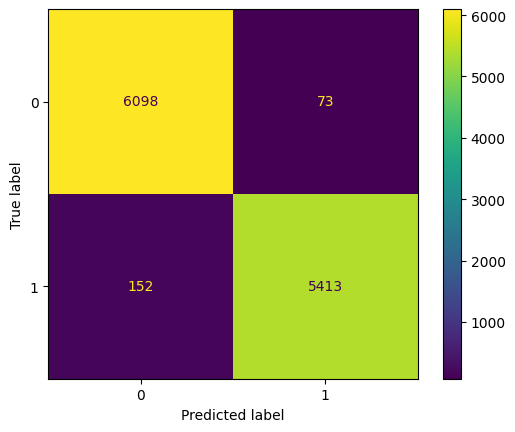

In [38]:
import sklearn
!pip install matplotlib
import matplotlib.pyplot as plt
c = sklearn.metrics.confusion_matrix(y_test, predictions)
d = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=c)
d.plot()
plt.show()

In [48]:
new = pd.read_csv('train.csv')
new = preprocess_data(new)
new
model.predict(new)

650/650 [==============================] - 71s 109ms/step


array([[3.8363978e-03],
       [2.2956533e-03],
       [4.7449652e-02],
       ...,
       [9.8696375e-01],
       [9.9965847e-01],
       [5.5605493e-04]], dtype=float32)

In [47]:
l = pd.read_csv('train.csv')
accuracy_score(l['label'],y_n)

0.2602403846153846

In [ ]:
""